# Assignment 6

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

In [2]:
# !pip install geopy

In [3]:
from geopy.distance import geodesic

### Loading Data

In [4]:
train_df = pd.read_csv('~/train-2.csv')
test_df = pd.read_csv('~/test-2.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [7]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [8]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


### Data Analysis & Visualization

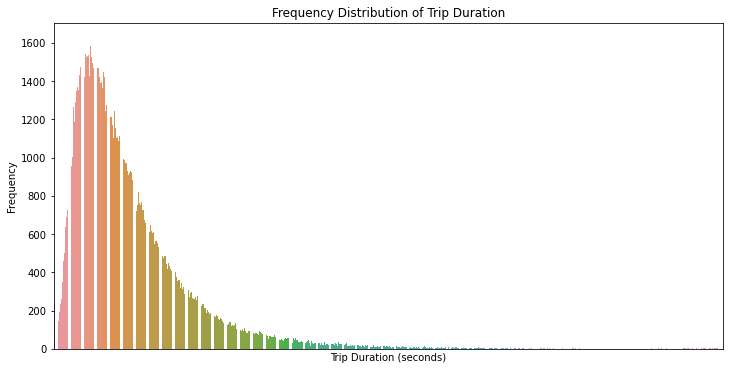

In [10]:
plt.figure(figsize=(12, 6)) 
sns.countplot(x=train_df['trip_duration'])
plt.title('Frequency Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.xticks([])
plt.show()

In [11]:
quantiles = train_df['trip_duration'].quantile([0.25, 0.5, 0.75, 0.8,0.85,0.9,0.95,0.99,0.998,0.999])

print("Quantiles:")
print(quantiles)

Quantiles:
0.250      397.000
0.500      662.000
0.750     1075.000
0.800     1208.000
0.850     1383.000
0.900     1634.000
0.950     2104.000
0.990     3440.000
0.998     5551.714
0.999    85128.357
Name: trip_duration, dtype: float64


In [12]:
cnt = (train_df['trip_duration'] > 10000).sum()

print(f"Number of trips with duration more than 10000 seconds: {cnt}")


Number of trips with duration more than 10000 seconds: 2123


In [13]:
df1 = train_df[train_df['trip_duration'] <= 10000]

In [14]:
df1['store_and_fwd_flag'].value_counts()

N    1448476
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [15]:
df1['vendor_id'].value_counts()

2    778202
1    678319
Name: vendor_id, dtype: int64

In [16]:
test_df['store_and_fwd_flag'].value_counts()

N    621704
Y      3430
Name: store_and_fwd_flag, dtype: int64

In [17]:
df1['pickup_datetime'] = pd.to_datetime(df1['pickup_datetime'])

df1['pickup_day'] = df1['pickup_datetime'].dt.day_name()
df1['pickup_time'] = df1['pickup_datetime'].dt.time
df1['pickup_date'] = df1['pickup_datetime'].dt.date


/var/folders/19/xjp0qn2d7y3bwrd_pdq5v8cc0000gn/T/ipykernel_15044/1869762980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['pickup_datetime'] = pd.to_datetime(df1['pickup_datetime'])
/var/folders/19/xjp0qn2d7y3bwrd_pdq5v8cc0000gn/T/ipykernel_15044/1869762980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['pickup_day'] = df1['pickup_datetime'].dt.day_name()
/var/folders/19/xjp0qn2d7y3bwrd_pdq5v8cc0000gn/T/ipykernel_15044/1869762980.py:4: SettingWithCopyWarning: 
A value is trying to be set 

In [18]:
df1.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_time,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,17:24:55,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,00:43:35,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,11:35:24,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,19:32:31,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,13:30:55,2016-03-26


In [19]:
def calculate_distance(row):
    pickup_coords = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff_coords = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(pickup_coords, dropoff_coords).miles

df1['distance'] = df1.apply(calculate_distance, axis=1)

/var/folders/19/xjp0qn2d7y3bwrd_pdq5v8cc0000gn/T/ipykernel_15044/1107898635.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['distance'] = df1.apply(calculate_distance, axis=1)


In [20]:
df1.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_time,pickup_date,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,17:24:55,2016-03-14,0.933406
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,00:43:35,2016-06-12,1.123849
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,11:35:24,2016-01-19,3.964154
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,19:32:31,2016-04-06,0.921886
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,13:30:55,2016-03-26,0.737591


In [25]:
quantiles1 = df1['distance'].quantile([0.25, 0.5, 0.75, 0.8,0.85,0.9,0.95,0.99,0.998,0.999])

print("Quantiles:")
print(quantiles1)

Quantiles:
0.250     0.765627
0.500     1.300933
0.750     2.406998
0.800     2.868919
0.850     3.547470
0.900     4.740197
0.950     6.848520
0.990    12.930217
0.998    14.228146
0.999    15.374517
Name: distance, dtype: float64


In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456521 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1456521 non-null  object        
 1   vendor_id           1456521 non-null  int64         
 2   pickup_datetime     1456521 non-null  datetime64[ns]
 3   dropoff_datetime    1456521 non-null  object        
 4   passenger_count     1456521 non-null  int64         
 5   pickup_longitude    1456521 non-null  float64       
 6   pickup_latitude     1456521 non-null  float64       
 7   dropoff_longitude   1456521 non-null  float64       
 8   dropoff_latitude    1456521 non-null  float64       
 9   store_and_fwd_flag  1456521 non-null  object        
 10  trip_duration       1456521 non-null  int64         
 11  pickup_day          1456521 non-null  object        
 12  pickup_time         1456521 non-null  object        
 13  pickup_date 

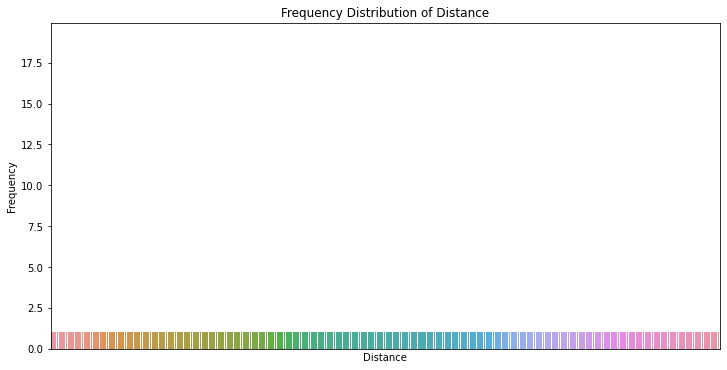

In [35]:

plt.figure(figsize=(12, 6)) 
sns.countplot(x=df1[:5000]['distance'])
plt.title('Frequency Distribution of Distance')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.xticks([])
plt.show()


In [36]:
df1['distance_bins'] = pd.cut(df1['distance'], bins=range(0, int(df1['distance'].max()) + 1, 1)) 

/var/folders/19/xjp0qn2d7y3bwrd_pdq5v8cc0000gn/T/ipykernel_15044/2731115785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['distance_bins'] = pd.cut(df1['distance'], bins=range(0, int(df1['distance'].max()) + 1, 1))


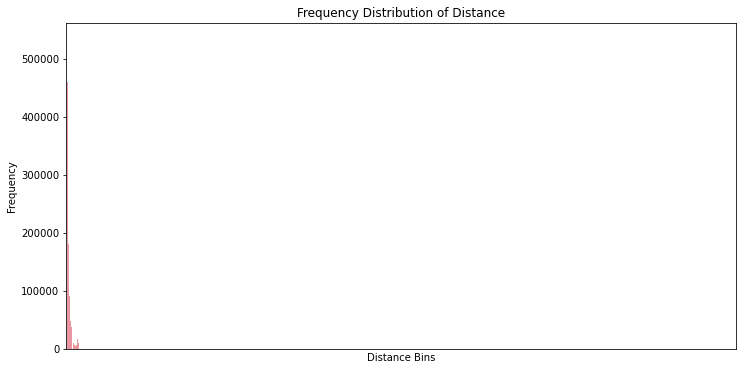

In [39]:

plt.figure(figsize=(12, 6))
sns.countplot(x='distance_bins', data=df1)
plt.title('Frequency Distribution of Distance')
plt.xlabel('Distance Bins')
plt.ylabel('Frequency')
plt.xticks([])
plt.show()

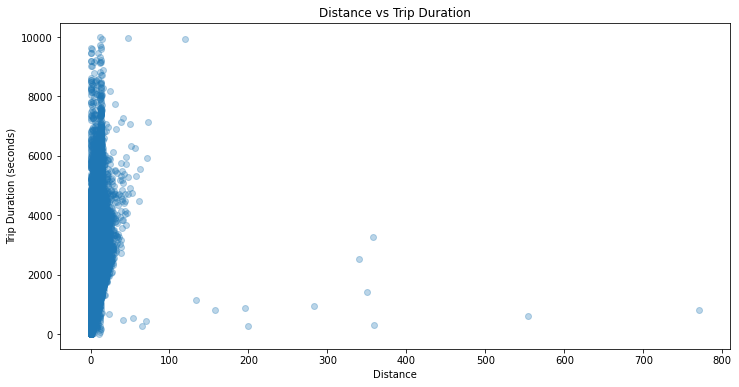

In [42]:
plt.figure(figsize=(12, 6))
plt.scatter(df1['distance'], df1['trip_duration'], alpha=0.3)
plt.title('Distance vs Trip Duration')
plt.xlabel('Distance')
plt.ylabel('Trip Duration (seconds)')
plt.show()

### Feature Extraction and Selection

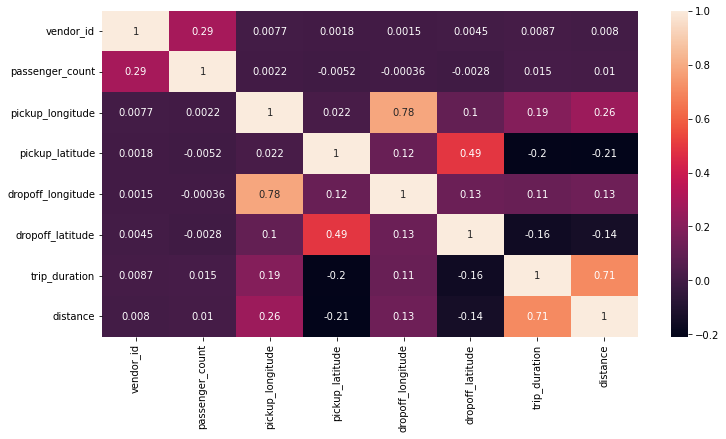

In [43]:
plt.figure(figsize=(12, 6))
correlation_matrix = df1.corr()
sns.heatmap(correlation_matrix, annot=True)

plt.show()

In [46]:
df1.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_time,pickup_date,distance,distance_bins
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,17:24:55,2016-03-14,0.933406,"(0, 1]"
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,00:43:35,2016-06-12,1.123849,"(1, 2]"
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,11:35:24,2016-01-19,3.964154,"(3, 4]"
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,19:32:31,2016-04-06,0.921886,"(0, 1]"
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,13:30:55,2016-03-26,0.737591,"(0, 1]"


In [45]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456521 entries, 0 to 1458643
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1456521 non-null  object        
 1   vendor_id           1456521 non-null  int64         
 2   pickup_datetime     1456521 non-null  datetime64[ns]
 3   dropoff_datetime    1456521 non-null  object        
 4   passenger_count     1456521 non-null  int64         
 5   pickup_longitude    1456521 non-null  float64       
 6   pickup_latitude     1456521 non-null  float64       
 7   dropoff_longitude   1456521 non-null  float64       
 8   dropoff_latitude    1456521 non-null  float64       
 9   store_and_fwd_flag  1456521 non-null  object        
 10  trip_duration       1456521 non-null  int64         
 11  pickup_day          1456521 non-null  object        
 12  pickup_time         1456521 non-null  object        
 13  pickup_date 

In [52]:
# After observing the feature correlations and analysis, i felt to remove the id, passenger_count.

df1 = df1.drop(['id', 'passenger_count','pickup_date'], axis=1)

In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456521 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   vendor_id           1456521 non-null  int64         
 1   pickup_datetime     1456521 non-null  datetime64[ns]
 2   dropoff_datetime    1456521 non-null  object        
 3   pickup_longitude    1456521 non-null  float64       
 4   pickup_latitude     1456521 non-null  float64       
 5   dropoff_longitude   1456521 non-null  float64       
 6   dropoff_latitude    1456521 non-null  float64       
 7   store_and_fwd_flag  1456521 non-null  object        
 8   trip_duration       1456521 non-null  int64         
 9   pickup_day          1456521 non-null  object        
 10  pickup_time         1456521 non-null  object        
 11  distance            1456521 non-null  float64       
 12  distance_bins       1450626 non-null  category      
dtypes: category(

In [58]:
df1['pickup_time1'] = pd.to_datetime(df1['pickup_time'].astype(str)).dt.hour * 60 + pd.to_datetime(df1['pickup_time'].astype(str)).dt.minute


In [60]:
# We can remove pickup_datetime, dropoff_datetime, pickup_time, distance_bins

df1 = df1.drop(['pickup_datetime', 'dropoff_datetime', 'pickup_time', 'distance_bins'], axis=1)

In [61]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456521 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1456521 non-null  int64  
 1   pickup_longitude    1456521 non-null  float64
 2   pickup_latitude     1456521 non-null  float64
 3   dropoff_longitude   1456521 non-null  float64
 4   dropoff_latitude    1456521 non-null  float64
 5   store_and_fwd_flag  1456521 non-null  object 
 6   trip_duration       1456521 non-null  int64  
 7   pickup_day          1456521 non-null  object 
 8   distance            1456521 non-null  float64
 9   pickup_time1        1456521 non-null  int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 122.2+ MB


In [62]:
# Lets convert the categorical variables, we can use one hot encoding.
df2 = pd.get_dummies(df1, columns=['store_and_fwd_flag','pickup_day'], drop_first=True)


In [64]:
# Final dataset with the features:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456521 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vendor_id             1456521 non-null  int64  
 1   pickup_longitude      1456521 non-null  float64
 2   pickup_latitude       1456521 non-null  float64
 3   dropoff_longitude     1456521 non-null  float64
 4   dropoff_latitude      1456521 non-null  float64
 5   trip_duration         1456521 non-null  int64  
 6   distance              1456521 non-null  float64
 7   pickup_time1          1456521 non-null  int64  
 8   store_and_fwd_flag_Y  1456521 non-null  uint8  
 9   pickup_day_Monday     1456521 non-null  uint8  
 10  pickup_day_Saturday   1456521 non-null  uint8  
 11  pickup_day_Sunday     1456521 non-null  uint8  
 12  pickup_day_Thursday   1456521 non-null  uint8  
 13  pickup_day_Tuesday    1456521 non-null  uint8  
 14  pickup_day_Wednesday  1456521 non-

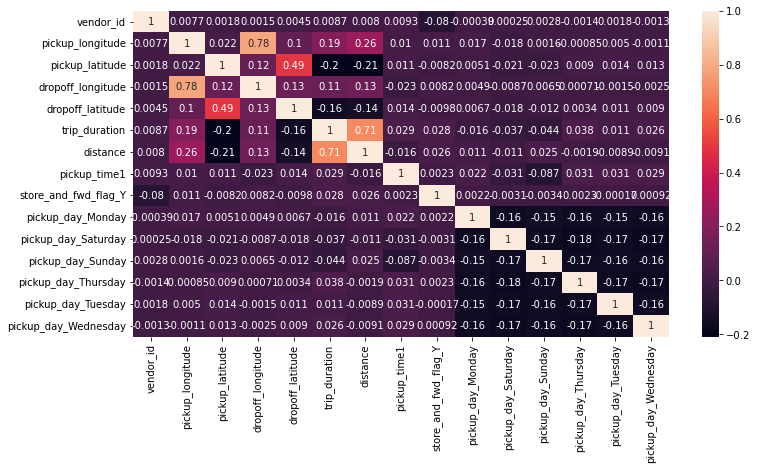

In [65]:
plt.figure(figsize=(12, 6))
correlation_matrix = df2.corr()
sns.heatmap(correlation_matrix, annot=True)

plt.show()

In [66]:
train_df1 = df2.copy()

In [68]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456521 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vendor_id             1456521 non-null  int64  
 1   pickup_longitude      1456521 non-null  float64
 2   pickup_latitude       1456521 non-null  float64
 3   dropoff_longitude     1456521 non-null  float64
 4   dropoff_latitude      1456521 non-null  float64
 5   trip_duration         1456521 non-null  int64  
 6   distance              1456521 non-null  float64
 7   pickup_time1          1456521 non-null  int64  
 8   store_and_fwd_flag_Y  1456521 non-null  uint8  
 9   pickup_day_Monday     1456521 non-null  uint8  
 10  pickup_day_Saturday   1456521 non-null  uint8  
 11  pickup_day_Sunday     1456521 non-null  uint8  
 12  pickup_day_Thursday   1456521 non-null  uint8  
 13  pickup_day_Tuesday    1456521 non-null  uint8  
 14  pickup_day_Wednesday  1456521 non-

### Model Creation

In [73]:
# Random forest classifier model

In [ ]:
X = train_df1.drop('trip_duration', axis=1)
y = train_df1['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

rmsle1 = np.sqrt(mean_squared_log_error(y_test, y_pred))

In [74]:
# SVR model 

In [ ]:
X = train_df1.drop('trip_duration', axis=1)
y = train_df1['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr_model = SVR(kernel='linear')  

svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)


rmsle2 = np.sqrt(mean_squared_log_error(y_test, y_pred))

In [75]:
# Ridge Regression

In [ ]:

X = train_df1.drop('trip_duration', axis=1)
y = train_df1['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rid = Ridge()
rid.fit(X_train, y_train)
y_pred = ridpredict(X_test)

rmsle3 = np.sqrt(mean_squared_log_error(y_test, y_pred))

In [ ]:
print(f"Mean squared logarithmic error of all types {rmsle1}, {rmsle2}, {rmsle3} ")